In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)
import shared_utils

from calitp_data_analysis.tables import tbls
import calitp_data_analysis.magics

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt

import importlib
from rt_analysis import rt_filter_map_plot

from IPython.display import display, Markdown, Latex, HTML
import json

In [30]:
## parameters cell
itp_id = 87

In [31]:
analysis_date = dt.date(2023, 3, 15) #v2! rerun April for SacRT?

In [32]:
%%capture_parameters
human_date = analysis_date.strftime('%B %d (%A)')
human_date

{"human_date": "March 15 (Wednesday)"}


In [33]:
%%capture
rt_day = rt_filter_map_plot.from_gcs(itp_id, analysis_date)

In [34]:
%%capture_parameters
organization_name = rt_day.organization_name
organization_name

{"organization_name": "City of Culver City"}


# {organization_name}

## About These Maps:

* Each map shows bus (and rail, if applicable) speeds for {organization_name}, with a map each for the morning peak, midday, and afternoon peak periods on {human_date}.
* On the map, routes are split into segments corresponding to the distance between two stops, allowing you to focus on specific portions of the route experiencing a slowdown.
* Route segments are arrow-shaped to indicate direction of travel. Thicker segments indicate more frequent transit routes.
* Hover over, or click, a segment with your mouse to see the exact speed, route name, and transit service frequency in that segment. 
    * Higher-frequency routes (3+ trips per hour) are especially important, since those slowdowns correspond to more vehicles, and riders, delayed in traffic.

## Morning Peak

In [35]:
%%capture
rt_day.set_filter(start_time='06:00', end_time='09:00')

In [36]:
## avoid papermill errors when map fails to render
m = None

In [37]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [38]:
m

In [11]:
rt_day.describe_slow_routes()

AM Peak slowest routes: 
 * 14, Bundy Dr & Centinela Ave, Northbound: 1.4 mph median trip speed for 1 trip
 * 1, Main St & Santa Monica Blvd/UCLA, Southbound: 3.5 mph median trip speed for 1 trip
 * 18, UCLA - Marina del Rey, Southbound: 3.6 mph median trip speed for 1 trip
 * 16, Wilshire Bl/Bundy Dr-Marina del Rey, Northbound: 5.9 mph median trip speed for 6 trips
 * 1, Main St & Santa Monica Blvd/UCLA, Northbound: 7.0 mph median trip speed for 4 trips
 * 9, Pacific Palisades, Northbound: 7.4 mph median trip speed for 4 trips
 * 9, Pacific Palisades, Westbound: 7.4 mph median trip speed for 4 trips

## Midday

In [12]:
%%capture
rt_day.set_filter(start_time='10:00', end_time='14:00')

In [13]:
## avoid papermill errors when map fails to render
m = None

In [14]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [15]:
m

In [16]:
rt_day.describe_slow_routes()

Midday slowest routes: 
 * 2, Wilshire Blvd/UCLA, Southbound: 6.0 mph median trip speed for 11 trips
 * 2, Wilshire Blvd/UCLA, Northbound: 6.6 mph median trip speed for 11 trips
 * 9, Pacific Palisades, Westbound: 6.7 mph median trip speed for 8 trips
 * 9, Pacific Palisades, Northbound: 6.7 mph median trip speed for 8 trips
 * 14, Bundy Dr & Centinela Ave, Southbound: 8.0 mph median trip speed for 11 trips
 * 1, Main St & Santa Monica Blvd/UCLA, Northbound: 8.5 mph median trip speed for 20 trips
 * 1, Main St & Santa Monica Blvd/UCLA, Southbound: 8.6 mph median trip speed for 21 trips

## Afternoon Peak

In [17]:
%%capture
rt_day.set_filter(start_time='15:00', end_time='19:00')

In [18]:
## avoid papermill errors when map fails to render
m = None

In [19]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [20]:
m

In [21]:
rt_day.describe_slow_routes()

PM Peak slowest routes: 
 * R7, Pico Blvd Rapid, Eastbound: 6.1 mph median trip speed for 4 trips
 * 2, Wilshire Blvd/UCLA, Southbound: 6.2 mph median trip speed for 10 trips
 * 14, Bundy Dr & Centinela Ave, Eastbound: 6.5 mph median trip speed for 4 trips
 * 14, Bundy Dr & Centinela Ave, Southbound: 6.9 mph median trip speed for 8 trips
 * 9, Pacific Palisades, Westbound: 7.1 mph median trip speed for 8 trips
 * 9, Pacific Palisades, Northbound: 7.1 mph median trip speed for 8 trips
 * 16, Wilshire Bl/Bundy Dr-Marina del Rey, Southbound: 7.2 mph median trip speed for 8 trips

In [22]:
try:
    metrics_df = (rt_day.rt_trips
         >> group_by(_.route_short_name, _.direction_id)
         >> summarize(speed_variance = _.mean_speed_mph.var(),
                     mean_speed_mph = _.mean_speed_mph.mean(),
                     min_hour = _.median_time.min().hour,
                     max_hour = _.median_time.max().hour,
                     n = _.route_short_name.size)
         >> filter(_.min_hour <= 7, _.max_hour >= 15,
                   _.mean_speed_mph < _.mean_speed_mph.quantile(.6),
                   _.speed_variance, _.n > _.n.quantile(.4))
         >> arrange(-_.speed_variance)
         >> head(20)
        )
except Exception as e:
    pass
    # print(e)
## check that route has all-day span...

In [23]:
def map_from_metrics(rt_day, metrics_df):
    def show_title_and_map():
        try:
            am_map = rt_day.segment_speed_map(how='low_speeds', no_title = True)
            display(Markdown(f'20th Percentile Vehicle Speeds Between Stops{rt_day.filter_formatted}'))
            display(am_map)
        except Exception as e:
            display(Markdown(f'Map not available for this time/route'))
            pass
        return
    try:
        route_name = metrics_df.iloc[1,0]
        direction_id = metrics_df.iloc[1,1]
        # print(route_name, direction_id)
    except Exception as e:
        # print(e)
        return
    rt_day.set_filter(start_time='06:00', end_time='09:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()
    
    rt_day.set_filter(start_time='10:00', end_time='14:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()

    rt_day.set_filter(start_time='15:00', end_time='19:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()

    return

## Daily Speed Patterns

* This chart shows the distribution of median trip speeds throughout the day. It can help find times of day where transit riders experience the slowest overall speeds.

Median Trip Speed by Hour of Day, All Route Types, All Routes, 06:00–22:00, Mar 15, 2023 (Wed)

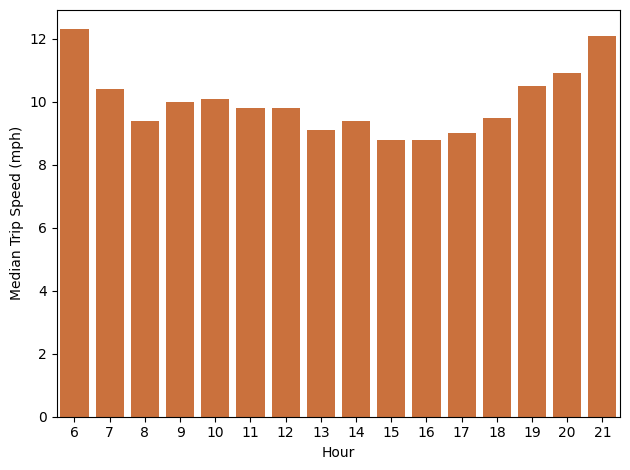

In [24]:
try:
    rt_day.set_filter(start_time='06:00', end_time='22:00')
    display(Markdown(f'Median Trip Speed by Hour of Day{rt_day.filter_formatted}'))

    rt_day.chart_speeds(no_title=True);
except:
    display(Markdown(f'Chart not available for this agency'))
    pass

## Single-Route Detail Example

* These maps highlight a single route which runs throughout the day, with a low average trip speed and a high amount of variation in speeds between different trips.

In [25]:
try:
    map_from_metrics(rt_day, metrics_df)
except Exception as e:
    # print(e)
    pass

20th Percentile Vehicle Speeds Between Stops, All Route Types, Route(s) 41, AM Peak, Mar 15, 2023 (Wed)

20th Percentile Vehicle Speeds Between Stops, All Route Types, Route(s) 41, Midday, Mar 15, 2023 (Wed)


KeyboardInterrupt



## Single Route Speed Variability

* This chart shows the _variability_ in speeds experienced by afternoon peak trips on the route mapped above. In this chart, each vertical strip corresponds to a segment of the map above. Within each strip, each dot represents the speed experienced in that segment by each trip in the afternoon peak. The segments are labelled by their end stop, generally a cross-street. Segments with high variability (some fast trips and some slow trips) might be better-suited to a different set of projects than segments that experience consistently slow speeds.

In [ ]:
try:
    rt_day.filter['shape_ids'] = [(rt_day._filter(rt_day.rt_trips) >> count(_.shape_id)).shape_id.iloc[0]]

    display(Markdown(f'Speed Variablity by Stop Segment{rt_day.filter_formatted}'))

    ## filter to a max number of segments to display, split out title
    rt_day.chart_variability(num_segments=30, no_title=True);
except:
    display(Markdown(f'Chart not available for this agency'))
    pass